In [1]:
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torch import autograd
from torch.autograd import Variable
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import pickle

import torchvision
import torch.nn.functional as F
import torch.optim as optim

In [2]:
torch.manual_seed(0)
device = 'cuda:1' if torch.cuda.is_available() else 'cpu'
img_size = 28 # Image size
batch_size = 2**6  # Batch size

# Model
z_size = 100
generator_layer_size = [256, 512, 1024]
discriminator_layer_size = [1024, 512, 256]

class_list = [str(i) for i in range(10)]
class_num = len(class_list)

transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))])
dataset = torchvision.datasets.MNIST(root='./data', train=True,
                                        download=True, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

In [3]:
class Generator(nn.Module):
    def __init__(self, generator_layer_size, z_size, img_size, class_num):
        super().__init__()
        self.z_size = z_size
        self.img_size = img_size
        self.label_emb = nn.Embedding(class_num, class_num)
        self.model = nn.Sequential(
            nn.Linear(self.z_size + class_num, generator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[0], generator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[1], generator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(generator_layer_size[2], self.img_size * self.img_size),
            nn.Tanh()
        )
    
    def forward(self, z, labels):
        z = z.view(-1, self.z_size)
        c = self.label_emb(labels)
        x = torch.cat([z, c], 1)
        out = self.model(x)
        return out.view(-1, self.img_size, self.img_size)



class Discriminator(nn.Module):
    def __init__(self, discriminator_layer_size, img_size, class_num):
        super().__init__()
        self.label_emb = nn.Embedding(class_num, class_num)
        self.img_size = img_size
        self.model = nn.Sequential(
            nn.Linear(self.img_size * self.img_size + class_num, discriminator_layer_size[0]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[0], discriminator_layer_size[1]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[1], discriminator_layer_size[2]),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Dropout(0.3),
            nn.Linear(discriminator_layer_size[2], 1),
            nn.Sigmoid()
        )
    
    def forward(self, x, labels):
        x = x.view(-1, self.img_size * self.img_size)
        c = self.label_emb(labels)
        x = torch.cat([x, c], 1)
        out = self.model(x)
        return out.squeeze()

[1/100] Generator loss: 1755.26; Discriminator loss: 914.13
[2/100] Generator loss: 1709.66; Discriminator loss: 790.87
[3/100] Generator loss: 3238.14; Discriminator loss: 381.34
[4/100] Generator loss: 3637.07; Discriminator loss: 328.22
[5/100] Generator loss: 3467.95; Discriminator loss: 373.66
[6/100] Generator loss: 3511.63; Discriminator loss: 340.40
[7/100] Generator loss: 3287.28; Discriminator loss: 402.96
[8/100] Generator loss: 2936.39; Discriminator loss: 440.72
[9/100] Generator loss: 2887.99; Discriminator loss: 447.82
[10/100] Generator loss: 2722.24; Discriminator loss: 486.01
[11/100] Generator loss: 2506.75; Discriminator loss: 536.00
[12/100] Generator loss: 2277.09; Discriminator loss: 594.32
[13/100] Generator loss: 2018.35; Discriminator loss: 664.78
[14/100] Generator loss: 1994.46; Discriminator loss: 668.28
[15/100] Generator loss: 2015.23; Discriminator loss: 668.18
[16/100] Generator loss: 1933.93; Discriminator loss: 697.71
[17/100] Generator loss: 1973.97;

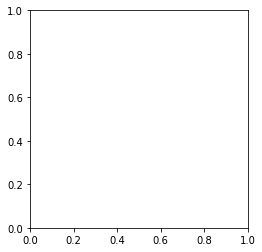

In [4]:
n_epochs = 100

try:
    generator = torch.load(f'CGAN-generator-{n_epochs}.pth')
    discriminator = torch.load(f'CGAN-discriminator-{n_epochs}.pth')
    f = open(f"CGAN-losses-{n_epochs}.pickle", 'rb')
    g_losses, d_losses = pickle.load(f)
    f.close()
except:
    torch.manual_seed(0)
    generator = Generator(generator_layer_size, z_size, img_size, class_num).to(device)
    discriminator = Discriminator(discriminator_layer_size, img_size, class_num).to(device)

    # Training
    learning_rate = 1e-4
    criterion = nn.BCELoss()
    g_optimizer = torch.optim.Adam(generator.parameters(), lr=learning_rate)
    d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=learning_rate)

    g_losses = []
    d_losses = []
    for epoch in range(n_epochs):
        if epoch % 10 == 0:
            generator.eval()
            z = Variable(torch.randn(class_num-1, z_size)).to(device)
            labels = Variable(torch.arange(9)).to(device)
            sample_images = generator(z, labels).unsqueeze(1).data.cpu()
            grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
            plt.imshow(grid)
            plt.axis('off')
            plt.title(f'Epoch {epoch}')
            plt.savefig(f'CGAN_epoch{epoch:02d}.svg')
            plt.cla()


        running_g_loss = 0
        running_d_loss = 0
        for i, (images, labels) in enumerate(data_loader):
            # Train data
            real_images = Variable(images).to(device)
            labels = Variable(labels).to(device)
            batch_size = len(real_images)
            generator.train()
            ### Train discriminator
            d_optimizer.zero_grad()
            real_validity = discriminator(real_images, labels)
            real_loss = criterion(real_validity, Variable(torch.ones(batch_size)).to(device))
            z = Variable(torch.randn(batch_size, z_size)).to(device)
            fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
            fake_images = generator(z, fake_labels)
            fake_validity = discriminator(fake_images, fake_labels)
            fake_loss = criterion(fake_validity, Variable(torch.zeros(batch_size)).to(device))
            d_loss = real_loss + fake_loss
            d_loss.backward()
            d_optimizer.step()

            ### Train generator
            g_optimizer.zero_grad()
            z = Variable(torch.randn(batch_size, z_size)).to(device)
            fake_labels = Variable(torch.LongTensor(np.random.randint(0, class_num, batch_size))).to(device)
            fake_images = generator(z, fake_labels)
            validity = discriminator(fake_images, fake_labels)
            g_loss = criterion(validity, Variable(torch.ones(batch_size)).to(device))
            g_loss.backward()
            g_optimizer.step()

            running_g_loss += g_loss.item()
            running_d_loss += d_loss.item()
        # Save losses
        g_losses.append(running_g_loss)
        d_losses.append(running_d_loss)
        print(f'[{epoch+1}/{n_epochs}] Generator loss: {running_g_loss:.2f}; Discriminator loss: {running_d_loss:.2f}')

    # save model
    torch.save(generator, f'CGAN-generator-{n_epochs}.pth')
    torch.save(discriminator, f'CGAN-discriminator-{n_epochs}.pth')
    # save losses
    losses = [g_losses, d_losses]
    f = open(f"CGAN-losses-{n_epochs}.pickle", "wb")
    pickle.dump(losses, f)
    f.close()

    generator.eval()
    z = Variable(torch.randn(class_num-1, z_size)).to(device)
    labels = Variable(torch.arange(9)).to(device)
    sample_images = generator(z, labels).unsqueeze(1).data.cpu()
    grid = make_grid(sample_images, nrow=3, normalize=True).permute(1,2,0).numpy()
    plt.imshow(grid)
    plt.axis('off')
    plt.title(f'Epoch {n_epochs}')
    plt.savefig(f'CGAN_epoch{n_epochs:02d}.svg')
    plt.cla()


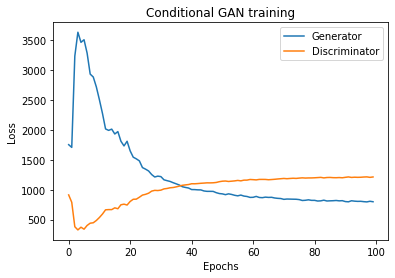

In [5]:
# plot the losses
plt.plot(g_losses, label='Generator')
plt.plot(d_losses, label='Discriminator')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Conditional GAN training')
plt.savefig('CGAN_losses.svg')
plt.show()

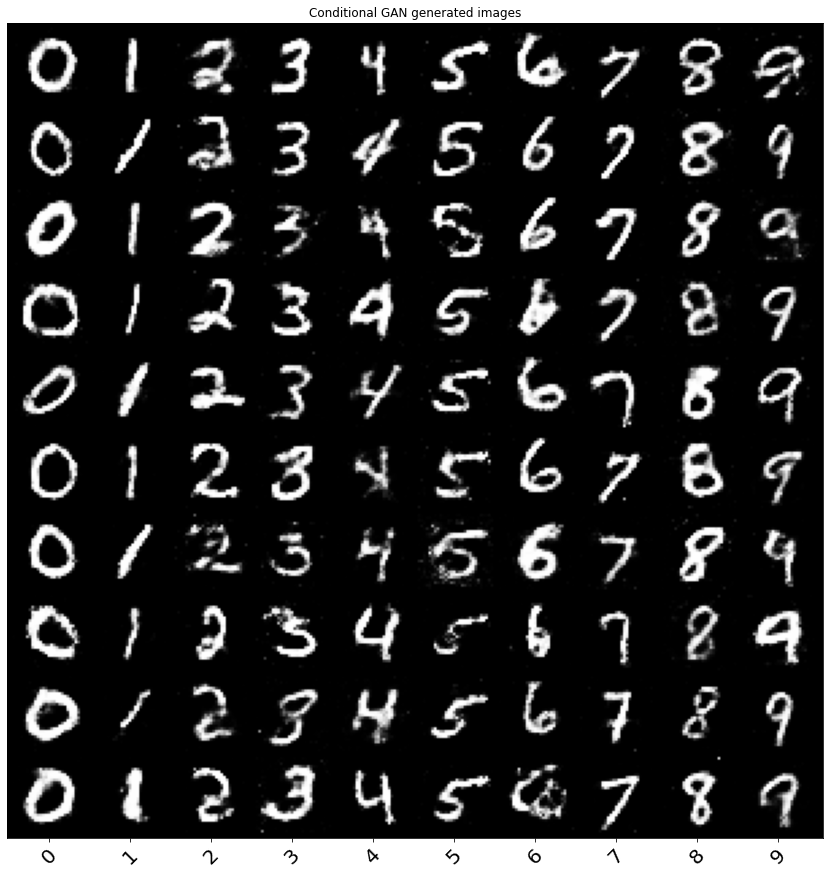

In [6]:
z = Variable(torch.randn(z_size, z_size)).to(device)
labels = Variable(torch.LongTensor([i for _ in range(class_num) for i in range(class_num)])).to(device)
sample_images = generator(z, labels).unsqueeze(1).data.cpu()

grid = make_grid(sample_images, nrow=class_num, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(grid)
_ = plt.yticks([])
_ = plt.xticks(np.arange(15, 300, 30), class_list, rotation=45, fontsize=20)
plt.title('Conditional GAN generated images')
plt.savefig('CGAN_generated.svg')
plt.show()

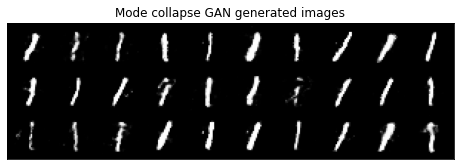

In [7]:
z = Variable(torch.randn(z_size, z_size)).to(device)
labels = Variable(torch.LongTensor([1 for _ in range(10) for i in range(10)])).to(device)
sample_images = generator(z, labels).unsqueeze(1).data.cpu()

grid = make_grid(sample_images[:30], nrow=10, normalize=True).permute(1,2,0).numpy()
fig, ax = plt.subplots(figsize=(8, 10))
ax.imshow(grid)
plt.xticks([])
plt.yticks([])
plt.title('Mode collapse GAN generated images')
plt.savefig('Mode_collapse_GAN_generated.svg')
plt.show()